# Classifying the watershed
Going to start with a small section to classify the presence/absence of conifer trees in the watershed as well as the presence/absence of bare soil. The number of pixels of 200 m x 200 m grid with conifer trees should provide a percentage that I can use to assign UTM coordinates to sample site.


In [2]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
from osgeo import gdal
from osgeo import gdal_array
import rasterio as rio
#from rasterio import plot
from rasterio.plot import show
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import shapely
from shapely.geometry import box
from shapely.geometry import mapping
import geopandas as gpd
import cartopy.crs as ccrs
from glob import glob
import spectral
import earthpy.plot as ep
import shapefile as shp
#import ospybook as pb

import seaborn as sns
sns.set(font_scale=1.5, style="whitegrid")

In [3]:
#Set directory right to folder
in_dir = 'K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/'

# Creating area to test classification on
Skip if you do not wish to test your classification on a smaller section of the landscape

In [4]:
b3 = rxr.open_rasterio("Landsat C2 L2 BF/MergedLandSatBands/band3_clipped.tif")
b2 = rxr.open_rasterio("Landsat C2 L2 BF/MergedLandSatBands/band2_clipped.tif")
b4 = rxr.open_rasterio("Landsat C2 L2 BF/MergedLandSatBands/band4_clipped.tif")

In [5]:
#Define bounding box
minx, miny = -115.307, 55.104
maxx, maxy = -115.328, 55.122
bbox = box(minx, miny, maxx, maxy)

#Conver to geodataframe
bbox_df = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs='EPSG:4326')

# convert to EPSG:2955
bbox_UTM = bbox_df.to_crs('EPSG:2955')

# check:
#print(bbox_UTM.crs == rgb.crs)

# save to shapefile
bbox_UTM.to_file(in_dir + "bbox2_UTM.shp")

C:\Users\tribe\.conda\envs\geog250\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


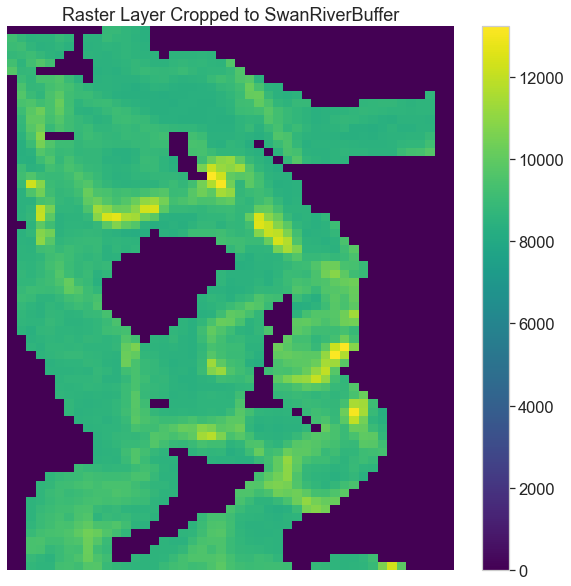

In [6]:
#clip the watershed clipped bands to bbox
b3_clip = b3.rio.clip(bbox_UTM.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      bbox_UTM.crs)

f, ax = plt.subplots(figsize=(10, 10))
b3_clip.plot(ax=ax)
ax.set(title="Raster Layer Cropped to SwanRiverBuffer")
ax.set_axis_off()
plt.show()

In [7]:
#Repeat for bands 2 and 4
b2_clip = b2.rio.clip(bbox_UTM.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      bbox_UTM.crs)
b4_clip = b4.rio.clip(bbox_UTM.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      bbox_UTM.crs)

In [8]:
#Export files
path_to_tif_file4 = os.path.join("Landsat C2 L2 BF", "MergedLandSatBands","b4_comptest2.tif") 
path_to_tif_file3 = os.path.join("Landsat C2 L2 BF", "MergedLandSatBands","b3_comptest2.tif") 
path_to_tif_file2 = os.path.join("Landsat C2 L2 BF", "MergedLandSatBands","b2_comptest2.tif") 
# Write the data to a new geotiff file
b4_clip.rio.to_raster(path_to_tif_file4)
b3_clip.rio.to_raster(path_to_tif_file3)
b2_clip.rio.to_raster(path_to_tif_file2)

In [9]:
landsat_comptest = os.path.join("Landsat C2 L2 BF", "MergedLandsatBands")
post_comptest = glob(os.path.join(landsat_comptest,
                                        "*comptest2*.TIF"))
post_comptest.sort()
post_comptest

['Landsat C2 L2 BF\\MergedLandsatBands\\b2_comptest2.tif',
 'Landsat C2 L2 BF\\MergedLandsatBands\\b3_comptest2.tif',
 'Landsat C2 L2 BF\\MergedLandsatBands\\b4_comptest2.tif']

In [10]:
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

In [11]:
comptest_bands = []
for i, aband in enumerate(post_comptest):
    comptest_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    comptest_bands[i]["band"]=i+1

In [12]:
swanriver_comptest = xr.concat(comptest_bands, dim="band") 

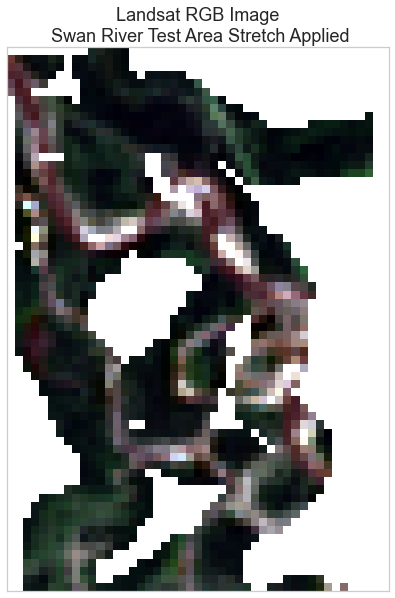

In [13]:
ep.plot_rgb(swanriver_comptest.values,
            rgb=[2,1,0],
            title="Landsat RGB Image\n Swan River Test Area Stretch Applied",
            stretch=True,
            str_clip=1)
plt.show()

In [14]:
#runnning composite code
b2_Arr = gdal_array.LoadFile(in_dir + 'b2_comptest2.tif')
b3_Arr = gdal_array.LoadFile(in_dir + 'b3_comptest2.tif')
b4_Arr = gdal_array.LoadFile(in_dir + 'b4_comptest2.tif')
def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))
b2_norm = norm(b2_Arr.astype(float))
b3_norm = norm(b3_Arr.astype(float))
b4_norm = norm(b4_Arr.astype(float))
rgb = np.dstack((b4_norm,b3_norm,b2_norm))

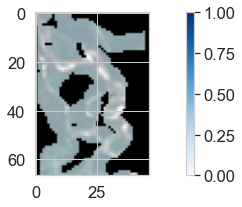

In [15]:
Zpos = np.ma.masked_less(rgb, 0)
Zneg = np.ma.masked_greater(rgb, 0)
fig, (ax1) = plt.subplots(figsize=(13, 3), ncols=1)
pos = ax1.imshow(Zpos, cmap='Blues', interpolation='none')
fig.colorbar(pos, ax=ax1)
plt.imshow(rgb)

# Now to attempt classification
source:https://ml-gis-service.com/index.php/2020/10/14/data-science-unsupervised-classification-of-satellite-images-with-k-means-algorithm/ 

In [18]:
import matplotlib.pyplot as plt
   ...: from kneed import KneeLocator
   ...: from sklearn.datasets import make_blobs
   ...: from sklearn.cluster import KMeans
   ...: from sklearn.metrics import silhouette_score
   ...: from sklearn.preprocessing import StandardScaler
from skimage.exposure import equalize_adapthist
from osgeo import osr


In [19]:
#Create pathway to file - modify for test image
in_dir_2 = 'K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands2/'

In [20]:
#Load the bands you want to use - modify to use test image
complete_dataset = os.listdir(in_dir_2)
complete_dataset = [in_dir_2 + x for x in complete_dataset]
print(complete_dataset)

['K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands2/band2_clipped.tif', 'K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands2/band3_clipped.tif', 'K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands2/band4_clipped.tif']


In [21]:
#This code was included in instructions but did not end up needing to be used.
#%%time
#with rio.open('K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands/band2_clipped.tif') as src:
 #   b4_clip_meta = src.meta
  #  b4_crs = src.crs
   # b4_extent = rio.plot.plotting_extent(src)
    
#print(b4_clip_meta)

In [22]:
#This code should create the composite image, I don't know if it does
#def show_rgb(bands_list, red=4, green=3, blue=2):
 #   stack = []
    
  #  colors = [red, green, blue]
  #  colors = ['b' + str(x) for x in colors]
    
  #  for color in colors:
   #     for band in bands_list:
    #        if color in band:
     #           with rio.open(band) as src:
    #                array = src.read(1)
    #                stack.append(array)
    #            break
                
   # stack = np.dstack(stack)
   # for i in range(0, 3):
   #     stack[:, :, i] = equalize_adapthist(stack[:, :, i])
        
   # plt.figure(figsize=(15,15))
   # plt.axis('off')
   # plt.imshow(rgb)
   # plt.show()
#show_rgb(complete_dataset)

In [23]:
#Unneccessary code? The tutorial said it was neccessary 
#so saving it in case of error
#kmeans = kmeans(n_clusters=number of clusters)
#y_pred = kmeans.fit_predict(data rgb)

In [24]:
#classification code
class ClusteredBands:
    
    def __init__(self, rasters_list): #you can modify this to select certain bands, I am running all bands because there are only 3 in the folder
        self.rasters = rasters_list 
        self.model_input = None
        self.width = 0
        self.height = 0
        self.depth = 0
        self.no_of_ranges = None
        self.models = None
        self.predicted_rasters = None
        self.s_scores = []
        self.inertia_scores = []
        
    def set_raster_stack(self): #development of the raster stack
        band_list = []
        for image in self.rasters:
            with rio.open(image, 'r') as src:
                band = src.read(1)
                band = np.nan_to_num(band) #converts nan values to 0's
                band_list.append(band)
        bands_stack = np.dstack(band_list)
        
        # Prepare model input from bands stack
        self.width, self.height, self.depth = bands_stack.shape
        self.model_input = bands_stack.reshape(self.width * self.height, self.depth)
        
    def build_models(self, no_of_clusters_range): #can be used to build multiple models
        self.no_of_ranges = no_of_clusters_range #must be a list of natural numbers
        models = []
        predicted = []
        inertia_vals = []
        s_scores = []
        for n_clust in no_of_clusters_range:
            kmeans = KMeans(n_clusters=n_clust)
            y_pred = kmeans.fit_predict(self.model_input)
            
            # Append model
            models.append(kmeans)
            
            # Calculate metrics
            s_scores.append(self._calc_s_score(y_pred))
            inertia_vals.append(kmeans.inertia_)
            
            # Append output image (classified)
            quantized_raster = np.reshape(y_pred, (self.width, self.height))
            predicted.append(quantized_raster)
            
        # Update class parameters
        self.models = models
        self.predicted_rasters = predicted
        self.s_scores = s_scores
        self.inertia_scores = inertia_vals
        
    def _calc_s_score(self, labels):
        s_score = silhouette_score(self.model_input, labels, sample_size=1000)
        return s_score
        
    def show_clustered(self):
        for idx, no_of_clust in enumerate(self.no_of_ranges):
            title = 'Number of clusters: ' + str(no_of_clust)
            image = self.predicted_rasters[idx]
            plt.figure(figsize = (15,15))
            plt.axis('off')
            plt.title(title)
            plt.imshow(image, cmap='Accent')
            plt.colorbar()
            plt.show()
            
    def show_inertia(self):
        plt.figure(figsize = (10,10))
        plt.title('Inertia of the models')
        plt.plot(self.no_of_ranges, self.inertia_scores)
        plt.show()
        
    def show_silhouette_scores(self):
        plt.figure(figsize = (10,10))
        plt.title('Silhouette scores')
        plt.plot(self.no_of_ranges, self.s_scores)
        plt.show()

In [25]:
#Initialize object with list of bands
clustered_models = ClusteredBands(complete_dataset)
#Create band stack
clustered_models.set_raster_stack()

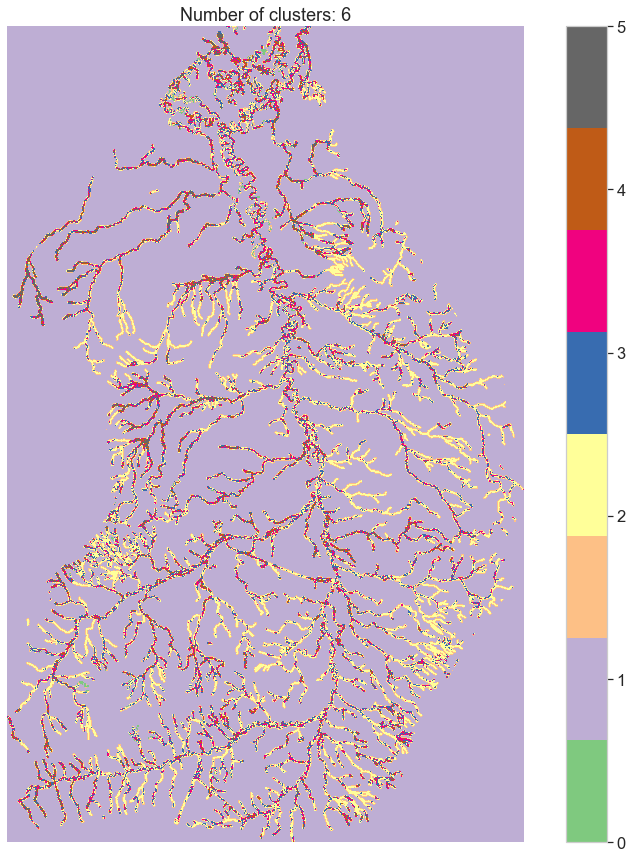

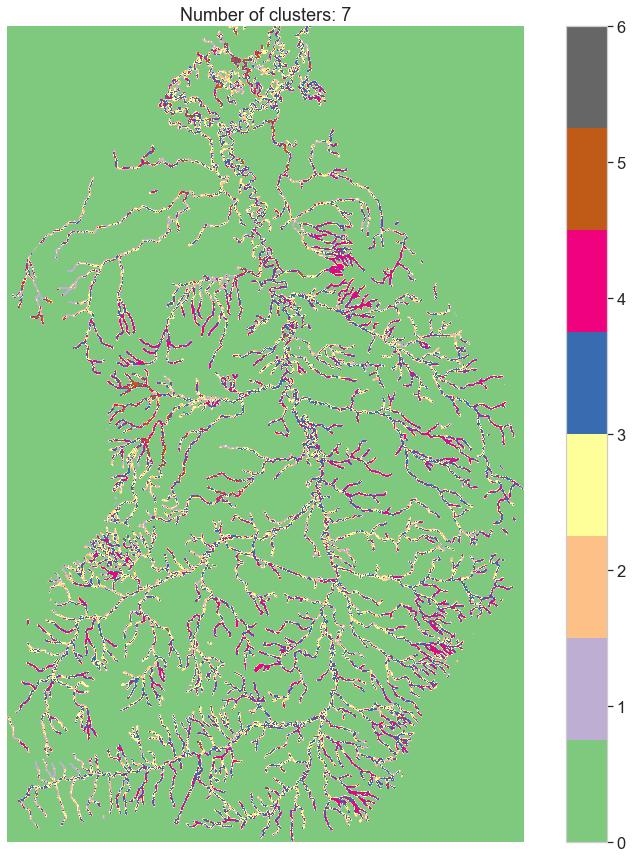

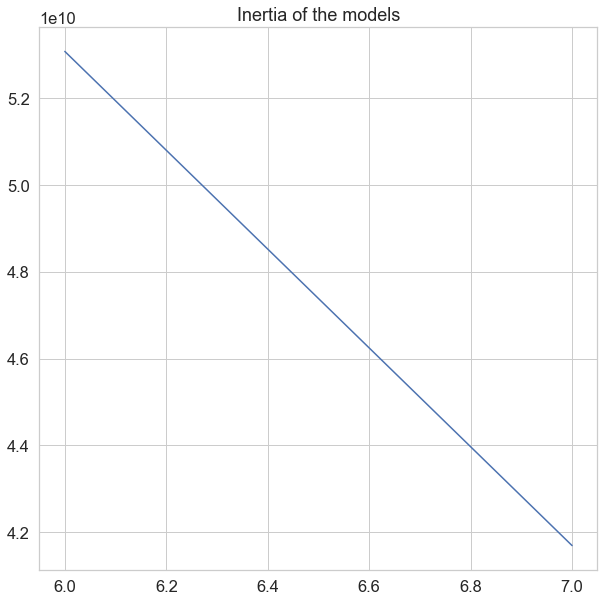

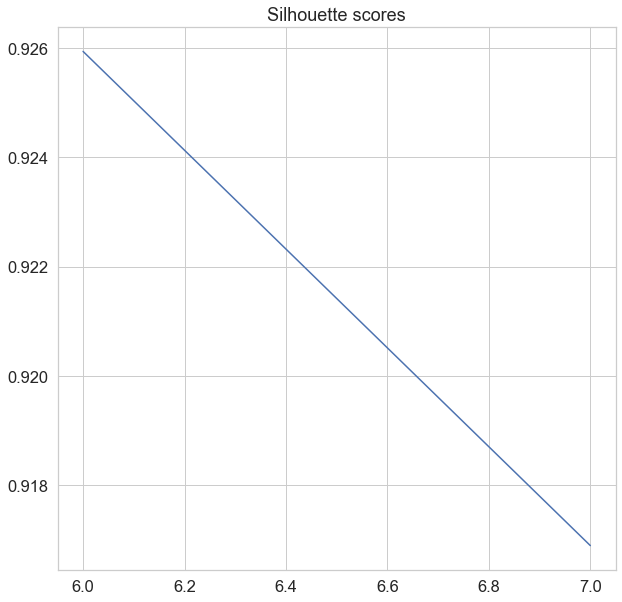

In [31]:
#Set number of ranges and create models
ranges = np.arange(6,8,1) #range of clusters you want to see(start, finish, 1)
clustered_models.build_models(ranges) #builds models
clustered_models.show_clustered() #returns maps of models
clustered_models.show_inertia() #returns graph of inertia
    #Interisa tells us how far the sample is from the category centroid
    #The elbow on the graph represents the optimal range 
clustered_models.show_silhouette_scores() #returns graph of Silhouette scores
    #Silhouette scores are an evaluation of algorithms based on distance between predicted
    #categories. +1 = good, -1 = bad and indicates the pixel is in the wrong cluster
    #This analysis takes a lot of time so alway set to 1000 not "all"

In [27]:
def get_spectral_indices(labeled_image: np.array, rasters: list) -> dict:
    """
    Function creates list of the unique spectral indices for each label from unsupervised classified image.
    
    :param labeled_image: (numpy array) classification output,
    :param rasters: (list) list of files with Landsat 8 bands.
    
    :returns: (dict) {raster: {label: [indices]}}
    """
    spectral_indices = {}
    
    for image in rasters:
        with rio.open(image, 'r') as src:
            
            band = src.read(1)
            band = np.nan_to_num(band)
            spectral_indices[image] = {}
            
            for lbl in np.unique(labeled_image):
                indices = band[labeled_image == lbl]
                unique_indices = np.unique(indices)
                spectral_indices[image][lbl] = unique_indices
    return spectral_indices

four_class_spectral_indices = get_spectral_indices(clustered_models.predicted_rasters[0], complete_dataset)

In [28]:
#Run to confirm array, but not neccessary
#print(four_class_spectral_indices)

{'K:\\geog250\\PythonSWR/Landsat C2 L2 BF/MergedLandSatBands/clipped_bands2/band2_clipped.tif': {0: array([0], dtype=uint16), 1: array([7301, 7360, 7429, 7453, 7514, 7521, 7548, 7574, 7579, 7583, 7597,
       7598, 7604, 7606, 7607, 7618, 7619, 7622, 7623, 7624, 7626, 7631,
       7635, 7637, 7645, 7648, 7650, 7653, 7656, 7661, 7662, 7663, 7664,
       7666, 7667, 7669, 7671, 7673, 7674, 7675, 7678, 7679, 7688, 7689,
       7691, 7694, 7695, 7697, 7698, 7699, 7700, 7701, 7702, 7704, 7706,
       7710, 7711, 7712, 7713, 7714, 7715, 7716, 7717, 7718, 7720, 7721,
       7722, 7723, 7724, 7726, 7727, 7728, 7729, 7730, 7731, 7733, 7734,
       7735, 7736, 7737, 7738, 7739, 7740, 7741, 7742, 7744, 7745, 7746,
       7747, 7749, 7750, 7751, 7752, 7753, 7754, 7755, 7756, 7757, 7758,
       7759, 7760, 7761, 7762, 7763, 7764, 7765, 7766, 7767, 7768, 7769,
       7770, 7771, 7772, 7773, 7774, 7775, 7776, 7777, 7778, 7779, 7780,
       7781, 7782, 7783, 7784, 7785, 7786, 7787, 7788, 7789, 7790, 7

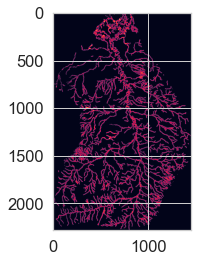

In [29]:
#Visualize the output
plt.imshow(clustered_models.predicted_rasters[0])

In [32]:
#redefine plot of cluster 6
clust6=clustered_models.predicted_rasters[0]

In [33]:
#Check type
print(type(clust6))

<class 'numpy.ndarray'>


In [37]:
#Save as a tif image source: https://gis.stackexchange.com/questions/37238/writing-numpy-array-to-raster-file 

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight, clust6):

    cols = clust6.shape[1]
    rows = clust6.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]
    

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(clust6)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(3400)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


def main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,clust6):
    reversed_arr = clust6[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster


if __name__ == "__main__":
    rasterOrigin = (453132.8469798209,6070115.7622602545)
    pixelWidth = 30 #in m
    pixelHeight = 30 #in m
    newRasterfn = 'clust6_23.tif'
    array = np.array(clust6)


    main(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,clust6)

